In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from math import ceil

In [2]:
print(os.getcwd())
with open("../../scores_withmeta.pickle", "rb") as f:
    scores = pickle.load(f)

if False:
    to_remove = [11]
    for key in scores:
        for i in to_remove:
            for j in range(len(scores[key])):
                if i == j:
                    print("removing", key, i)
                    scores[key].pop(j)
                    break
    with open("../../scores_withmeta.pickle", "wb") as f:
        pickle.dump(scores, f)

#sort which has alpha
for key in scores:
    timeouts = 0
    for i in range(len(scores[key])):
        if "timeout" in scores[key][i] and scores[key][i]["timeout"] == True:
            timeouts += 1
    print(key, timeouts)
    has_alpha = np.zeros((len(scores[key])), dtype=bool)
    for i in range(len(scores[key])):
        if "alpha" in scores[key][i]:
            has_alpha[i] = True
    scores[key] = [scores[key][i] for i in range(len(has_alpha)) if has_alpha[i]]

/home/ubuntu-compute/MassStorage/git/qdev_fastgates/bachelor/Condition evaluation Larmor
magnus1_x_virt_z_nooptim 0
corotating_xy_virt_z_nooptim 0
RWA_x_nooptim 0
commensurate_x_virt_z 0


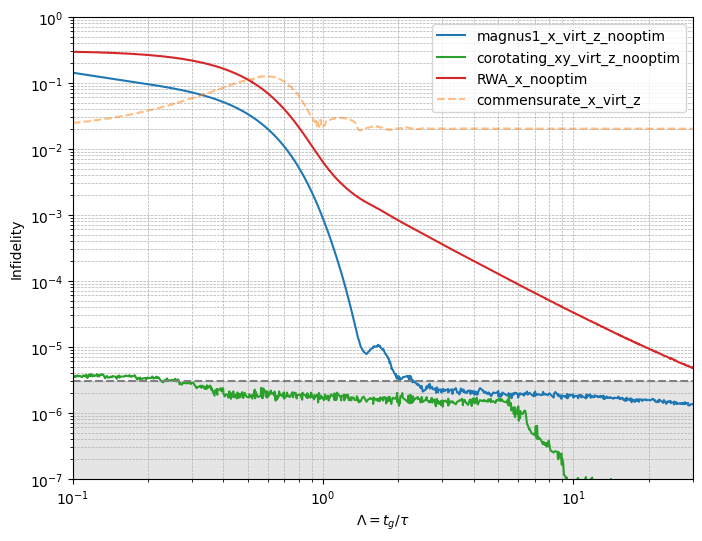

In [3]:
#do_simple
def do_simple(scores):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    all_lambdas = []
    colors = {
        "magnus": "tab:blue",
        "comm": "tab:orange",
        "cor": "tab:green",
        "RWA": "tab:red",
    }
    for i,key in enumerate(scores):
        if "old" in key or len(scores[key]) < 1:
            continue
        tgs = []
        omega_01s = []
        lambdas = []
        fidelity = []
        for i in range(len(scores[key])):
            tgs.append(scores[key][i]["t_g"])
            omega_01s.append(scores[key][i]["omega_01"])
            tau = (omega_01s[-1] / (2*np.pi))**(-1)
            lambdas.append(tgs[-1] / tau)
            fidelity.append(scores[key][i]["score"])
        tgs = np.array(tgs)
        omega_01s = np.array(omega_01s)
        lambdas = np.array(lambdas)
        all_lambdas += lambdas.tolist()
        fidelity = np.array(fidelity)
        #plot lambda and score
        #fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        mask = np.argsort(lambdas)
        l2plot = lambdas[mask]
        f2plot = fidelity[mask]
        c = "tab:blue"
        for ck in colors:
            if ck in key:
                c = colors[ck]
        line = "--"
        alpha = 0.5
        if "nooptim" in key:
            line = "-"
            alpha = 1
        nanmask = np.isnan(np.asarray(f2plot).astype(float))
        f2plot = f2plot[~nanmask]
        l2plot = l2plot[~nanmask]
        if np.sum(nanmask) > 0:
            print("nanmask", key, np.sum(nanmask))
        sc = ax.plot(l2plot, 1-f2plot, label=key,c=c, linestyle=line, alpha=alpha)  
        ax.set_xlabel(r"$\Lambda=t_g/\tau$")
        ax.set_ylabel("Infidelity")
        #ax.set_title(key)
    #make a horizontal line 2e-6, and grey out all under it
    if len(all_lambdas) > 0:
        mi = np.min(all_lambdas)
        ma = np.max(all_lambdas)
        ax.axhline(y=3e-6, color='grey', linestyle='--')
        ax.fill_betweenx([0, 3e-6], mi, ma, color='grey', alpha=0.2)
        plt.xlim([1e-1, ma])
        plt.yscale("log")
        plt.xscale("log")
        plt.ylim([1e-7,1])
        plt.legend()
        #with grid
        ax.grid(which='both', linestyle='--', linewidth=0.5)
        plt.savefig("fidelity_3level.png", dpi=300, bbox_inches='tight')
        plt.show()  


        

    
do_simple(scores)

In [4]:
def do2(force_res=None):
    if len(plot_axes) == 2:
        print("Doing 2D plot")
        score_maps = {}
        for key in scores:
            datapoints = scores[key]
            #check if plot axes are present
            timeouts = 0
            for i,dp in enumerate(datapoints):
                if "timeout" in dp.keys() and dp["timeout"]:
                    timeouts += 1
            print(f"Timeouts for scheme {key}: {timeouts}")
            mask = np.zeros(len(datapoints), dtype=bool)
            for i,dp in enumerate(datapoints):
                mask[i] = True
                for pa in plot_axes:
                    if not pa in dp.keys():
                        mask[i] = False
            datapoints = [dp for i,dp in enumerate(datapoints) if mask[i]]
            print(f"Threw out {np.sum(~mask)-timeouts} datapoints due to missing data")
            print(f"Length of set: {len(datapoints)}")
            
            distance_2_isoaxis = np.zeros(len(datapoints))
            for i,dp in enumerate(datapoints):
                for ia in iso_axes:
                    distance_2_isoaxis[i] += (dp[ia] - iso_axes[ia])**2
            distance_2_isoaxis = np.sqrt(distance_2_isoaxis)
            plot_axis_x = np.full(len(datapoints), np.nan)
            plot_axis_y = np.full(len(datapoints), np.nan)
            for i,dp in enumerate(datapoints):
                plot_axis_x[i] = dp[plot_axes[0]]
                plot_axis_y[i] = dp[plot_axes[1]]
            scores = np.zeros(len(datapoints))
            for i,dp in enumerate(datapoints):
                scores[i] = dp["score"]
            nanmask = np.isnan(plot_axis_x) | np.isnan(scores)
            plot_axis_x = plot_axis_x[~nanmask]
            plot_axis_y = plot_axis_y[~nanmask]
            scores = scores[~nanmask]
            distance_2_isoaxis = distance_2_isoaxis[~nanmask]
            lset = len(scores)
            #do a k=2 nearest neighbour plot
            from sklearn.neighbors import NearestNeighbors
            from tqdm import tqdm
            nbrs = NearestNeighbors(n_neighbors=5, algorithm='brute').fit(np.array([plot_axis_x, plot_axis_y]).T)
            res = ceil(np.sqrt(lset))
            res = 3 * res
            if force_res is not None: res = force_res
            X = np.linspace(np.min(plot_axis_x), np.max(plot_axis_x), res)
            Y = np.linspace(np.min(plot_axis_y), np.max(plot_axis_y), res)
            X, Y = np.meshgrid(X, Y)
            Z = np.zeros(X.shape)
            for i in tqdm(range(X.shape[0])):
                for j in range(X.shape[1]):
                    distances, indices = nbrs.kneighbors(np.array([[X[i,j], Y[i,j]]]))
                    Z[i,j] = scores[indices[0][1]]
                #the above but vectorized
                #distances, indices = nbrs.kneighbors(np.array([[X[i,j], Y[i,j]] for j in range(X.shape[1])]))
                #Z[i,:] = scores[indices[0][1:]]
            #as a first simple thing: plot this
            plt.imshow(Z, extent=(np.min(plot_axis_x), np.max(plot_axis_x), np.min(plot_axis_y), np.max(plot_axis_y)), origin="lower", aspect="auto")
            plt.colorbar(label="Fidelity")#, boundaries = (0.7,1.0))
            plt.clim(0.85, 1.0)
            plt.title(f'Scheme "{key}" fidelities')
            plt.xlabel(fr"${plot_axes[0]}$ [ns]")
            #make a secondary y-axis with the extra_axis
            #points = np.linspace(np.min(plot_axis_y), np.max(plot_axis_y), 10)
            #!todo
            #try:
            #    plt.ylabel(fr"$\{plot_axes[1]}$ [GHz]")
            #except:
            plt.ylabel(fr"${plot_axes[1]}$ [GHz]")
            #plt.scatter(plot_axis_x, plot_axis_y, c=distance_2_isoaxis, cmap="hot", norm=LogNorm(np.min(distance_2_isoaxis), np.max(distance_2_isoaxis)), s=10, alpha=0.7)
            plt.scatter(plot_axis_x, plot_axis_y, s=10, alpha=0.7, c="black")
            #plt.colorbar(label="Distance to isoaxis")
            plt.show()
            score_maps[key] = Z
        return score_maps

In [5]:
def do1(scores):
    if len(plot_axes) == 1:
        print("Doing 1D plot")
        for key in scores:#key is just the gate that is attempted
            datapoints = scores[key]
            print(f"Length of set: {len(datapoints)}")
            timeouts = 0
            for i,dp in enumerate(datapoints):
                if "timeout" in dp.keys() and dp["timeout"]:
                    timeouts += 1
            print(f"Of which, {timeouts} where thrown out due to timeouts")
            other_errors = 0
            for i,dp in enumerate(datapoints):
                if dp["score"] == None:# or not (np.isinstance(dp["score"], float) or np.isinstance(dp["score"], np.float64)):
                    other_errors += 1
            print(f"Of which, {other_errors-timeouts} where thrown out due to other errors")
            distance_2_isoaxis = np.zeros(len(datapoints))
            for i,dp in enumerate(datapoints):
                for ia in iso_axes:
                    distance_2_isoaxis[i] += (dp[ia] - iso_axes[ia])**2
            distance_2_isoaxis = np.sqrt(distance_2_isoaxis)
            plot_axis = np.full(len(datapoints), np.nan)
            for i,dp in enumerate(datapoints):
                plot_axis[i] = dp[plot_axes[0]]
            score_var = np.zeros(len(datapoints))
            for i,dp in enumerate(datapoints):
                score_var[i] = dp["score"]
            nanmask = np.isnan(plot_axis) & np.isnan(score_var) & (score_var==None)
            plot_axis = plot_axis[~nanmask]
            score_var = score_var[~nanmask]
            distance_2_isoaxis = distance_2_isoaxis[~nanmask]
            distance_cut_mask = distance_2_isoaxis < 1*np.max(distance_2_isoaxis)
            lset = len(plot_axis)
            enable_color = True
            plot_axis = plot_axis[distance_cut_mask]
            score_var = score_var[distance_cut_mask]
            distance_2_isoaxis = distance_2_isoaxis[distance_cut_mask]
            #make a cmap after the distance to the plot axis
            if True:#enable_color:
                cmap = plt.cm.hot
                #norm = LogNorm(np.min(distance_2_isoaxis), np.max(distance_2_isoaxis))
                plt.scatter(plot_axis, score_var, c=distance_2_isoaxis, cmap=cmap, s=10, alpha=0.7)
                #plt.scatter(plot_axis, scores)
                plt.colorbar(label="Distance to isoaxis")
            else:
                plt.scatter(plot_axis, scores, s=10, alpha=0.7)
            plt.title(f'Scheme "{key}" scores')
            plt.xlabel(fr"${plot_axes[0]}$ ns")
            plt.ylabel("Fidelity")
            #plt.xscale("log")
            plt.show()


In [6]:
plot_axes = [
    "t_g"
]
iso_axes = {
    "Ec": 1.3,
    "El": 0.59,
    "Ej": 5.71,
    "L1": 1.58e-4,
    "L2": 1.58e-4,
}
do1(scores)

Doing 1D plot
Length of set: 897
Of which, 0 where thrown out due to timeouts
Of which, 0 where thrown out due to other errors


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [ ]:
plot_axes = [
    "t_g",
    "alpha"
]
iso_axes = {
    "Ec": 1.3,
    "El": 0.59,
    "L1": 1.58e-4,
    "L2": 1.58e-4,
}
#do2()

In [ ]:
plot_axes = [
    "t_g",
    "Ej"
]
extra_axis = [
    None,
    "alpha"
]
iso_axes = {
    "Ec": 1.3,
    "El": 0.59,
    "L1": 1.58e-4,
    "L2": 1.58e-4,
}
do2()
score_maps = do2(force_res=60*3)

Doing 2D plot


UnboundLocalError: cannot access local variable 'scores' where it is not associated with a value

/tmp/ipykernel_1230023/567056556.py:57: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([0],[0],c=maps[0](0.5), s=100, label=f"Scheme = {list(scheme_scores_4_adaptive.keys())[0]}")
/tmp/ipykernel_1230023/567056556.py:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([0],[0],c=maps[1](0.5), s=100, label=f"Scheme = {list(scheme_scores_4_adaptive.keys())[1]}")


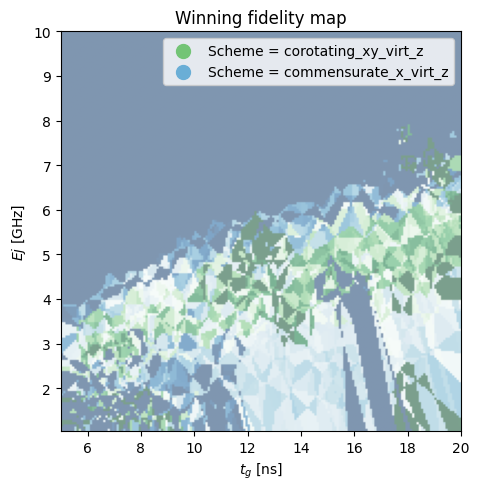

In [ ]:
key0 = list(score_maps.keys())[0]
cof_len = len(score_maps[key0])
cof_array = []
for i in range(len(score_maps[key0])):
    cof_array.append([])
    for j in range(len(score_maps[key0])):
        cof_array[i].append([])
        for k,key in enumerate(score_maps):
            cof_array[i][j].append(score_maps[key][i,j])
            #normalize 
        #cof_array[i][j] /= np.sum(cof_array[i][j])
        cof_array[i][j] -= np.min(cof_array[i][j])
        #cof_array[i][j] /= np.max(cof_array[i][j])
        cof_array[i][j] *= 80
cof_array = np.array(cof_array)

#not put the two datasets in the same picture with their own colormaps
cs = ["Greens", "Blues", "Reds"]
#green_map  = plt.get_cmap("Greens")
#red_map    = plt.get_cmap("Reds")
#blue_map   = plt.get_cmap("Blues")
maps = [plt.get_cmap(cs[i]) for i in range(len(cs))]
def cof2color(cof,maps):
    color_rgbs = []
    for i in range(len(cof)):
        rgb = maps[i](cof[i])
        color_rgbs.append(rgb)
    color_rgbs = np.array(color_rgbs)
    color_rgbs = np.mean(color_rgbs, axis=0)
    color_rgbs = np.array([color_rgbs[i] for i in range(len(color_rgbs)) if i != 3])
    return color_rgbs

#plot
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax.set_title("Winning fidelity map")
ax.set_xlabel(fr"${plot_axes[0]}$ [ns]")
ax.set_ylabel(fr"${plot_axes[1]}$ [GHz]")
Z_rgbs = np.zeros((cof_len, cof_len, 3))
for i in range(cof_len):
    for j in range(cof_len):
        Z_rgbs[i,j] = cof2color(cof_array[i,j], maps)
Z_rgbs = Z_rgbs.reshape((cof_len, cof_len, 3))
all_points = []
for key in scores:
    dps = scores[key]
    for dp in dps:
        axvar1 = dp[plot_axes[0]]
        axvar2 = dp[plot_axes[1]]
        all_points.append((axvar1,axvar2))
all_points = np.array(all_points).T
X = np.linspace(np.min(all_points[0]), np.max(all_points[0]), cof_len)
Y = np.linspace(np.min(all_points[1]), np.max(all_points[0]), cof_len)
X, Y = np.meshgrid(X, Y)
ax.imshow(Z_rgbs, extent=(np.min(all_points[0]), np.max(all_points[0]), np.min(all_points[1]), np.max(all_points[1])), origin="lower", aspect="auto")
ax.scatter([0],[0],c=maps[0](0.5), s=100, label=f"Scheme = {list(scores.keys())[0]}")
ax.scatter([0],[0],c=maps[1](0.5), s=100, label=f"Scheme = {list(scores.keys())[1]}")
plt.xlim(np.min(all_points[0]), np.max(all_points[0]))
plt.ylim(np.min(all_points[1]), np.max(all_points[1]))
plt.legend()
plt.show()